In [19]:
# Import the libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pickle

In [20]:
!git lfs pull

In [21]:
# Read the dataset
data = pd.read_csv("creditcard.csv")

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [23]:
#Removing the time column since it would not help in model training
data.drop(["Time"],axis=1,inplace = True)

In [24]:
# Lets check the missing values in case any
data.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [25]:
# Correlation of variables with the target class.
corr = data.corr()
corr["Class"]

V1       -0.101347
V2        0.091289
V3       -0.192961
V4        0.133447
V5       -0.094974
V6       -0.043643
V7       -0.187257
V8        0.019875
V9       -0.097733
V10      -0.216883
V11       0.154876
V12      -0.260593
V13      -0.004570
V14      -0.302544
V15      -0.004223
V16      -0.196539
V17      -0.326481
V18      -0.111485
V19       0.034783
V20       0.020090
V21       0.040413
V22       0.000805
V23      -0.002685
V24      -0.007221
V25       0.003308
V26       0.004455
V27       0.017580
V28       0.009536
Amount    0.005632
Class     1.000000
Name: Class, dtype: float64

In [26]:
# Removing the variables which can affect the output stream
#These are features either are too negatively correlated with the target or too much positive with target(may surpress other features)
COL=["V3","V10","V12","V14","V16","V17","V18"]
data.drop(COL,axis=1,inplace=True)

In [27]:
# Lets normalise the amount column
# Need not perform scaling of other features since all values have been scaled because of the PCA applied before the data was released
from sklearn.preprocessing import StandardScaler
data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Amount'],axis=1)

In [28]:
#Checking the ratio of classes with respect to each other 
data["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [29]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = data.sample(frac=1)

# NO of fraud instances :: 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V4,V5,V6,V7,V8,V9,V11,V13,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
270391,2.053419,-0.659802,0.627348,-0.392456,-0.443074,-0.355941,-0.150572,-0.353912,-1.521691,-0.885688,...,-0.043982,0.394016,0.015380,0.690210,0.269491,-0.346796,0.020517,-0.035796,0,-0.162401
150715,-11.397727,7.763953,6.711855,-10.174216,-4.395918,-15.893788,2.083013,-4.988837,7.093182,-0.148288,...,0.339007,1.342923,0.239217,0.534644,-0.174965,-0.500240,-1.722060,-0.574339,1,-0.307651
271324,0.345939,0.873389,-0.799491,1.523900,-1.294589,1.667240,-0.465510,-0.671628,-1.268252,-0.851743,...,0.297634,0.903713,-0.403804,0.670598,0.425013,0.923555,-0.114673,-0.041017,0,-0.345233
238222,-4.280584,1.421100,2.942946,-0.076205,-2.002526,-2.874155,-0.856005,0.963674,3.341802,-1.847443,...,-0.140062,-0.907720,-0.680108,-0.349170,0.056276,-1.149923,-1.809886,0.723051,1,-0.348831
222133,-3.613850,-0.922136,3.373001,-0.545207,-1.171301,-4.172315,1.517016,-1.775833,2.731576,1.547380,...,0.786787,0.893065,1.034907,0.097671,-1.345551,-0.788329,1.055442,0.099971,1,0.225693


In [30]:
# Lets split the data into features and target
features = new_df.drop(["Class"],axis =1)
target = new_df["Class"]
from sklearn.model_selection import train_test_split

# Splitting the data into train and test
X_train,X_test, Y_train,Y_test = train_test_split(features, target, test_size = .3, random_state =5)

<h1> GRID SEARCH CV </h1>
Lets apply the grid search in other to obtain our the best hyperparamter for our models 


In [31]:
# Logistic Regression 
# Solver is liblinear since its supports both l1 and l2 penalities
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],"solver" :['liblinear']}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, Y_train)
# We automatically get the logistic regression with the best parameters.

print(grid_log_reg.best_estimator_)

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, Y_train)
# KNears best estimator
print(grid_knears.best_estimator_)

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, Y_train)

# SVC best estimator

print(grid_svc.best_estimator_)

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, Y_train)

# tree best estimator
print(grid_tree.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')
SVC(C=0.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
      

<h1>LETS Train those models</h1>
We would be deploying cross validation score in order to get a much better result

In [32]:

k = KFold(n_splits = 5)
classifiers = {
    'Logistic Regression':grid_log_reg.best_estimator_,
               'Support Vector Machine' : grid_svc.best_estimator_,
               'Random Forest Classifier': RandomForestClassifier(),
               'Decision Tree Algorithm':grid_tree.best_estimator_,
               'KNN':grid_knears.best_estimator_
              }
def model(m):
    for i in m:
        print(i)
        print('-'*100)
        m[i].fit(X_train,Y_train.values.ravel())
        prediction = m[i].predict(X_test)
        print('Classification Report')        
        cr = classification_report(Y_test,prediction,output_dict=True)
        print(pd.DataFrame(cr).transpose())
        print('='*100)
        accuracy = accuracy_score(Y_test.values.ravel(),prediction)
        print('Accuracy Score :  ',accuracy)
        print('='*100)
        print('Cross Validation Score')
        cv=cross_val_score(m[i],X_train,Y_train,cv=k,scoring='accuracy')
        print(cv.mean())
        print('-'*100)

In [33]:
model(classifiers)

Logistic Regression
----------------------------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score     support
0              0.934641  0.953333  0.943894  150.000000
1              0.951049  0.931507  0.941176  146.000000
accuracy       0.942568  0.942568  0.942568    0.942568
macro avg      0.942845  0.942420  0.942535  296.000000
weighted avg   0.942734  0.942568  0.942554  296.000000
Accuracy Score :   0.9425675675675675
Cross Validation Score
0.9113191579392785
----------------------------------------------------------------------------------------------------
Support Vector Machine
----------------------------------------------------------------------------------------------------
Classification Report
              precision    recall  f1-score     support
0              0.916667  0.953333  0.934641  150.000000
1              0.950000  0.910959  0.930070  146.000000
accuracy       0.932432  0

In [34]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import numpy as np
import matplotlib.pyplot as plt
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'G:\\ANACONDA_Software\\lib\\site-packages\\matplotlib\\pyplot.py'>

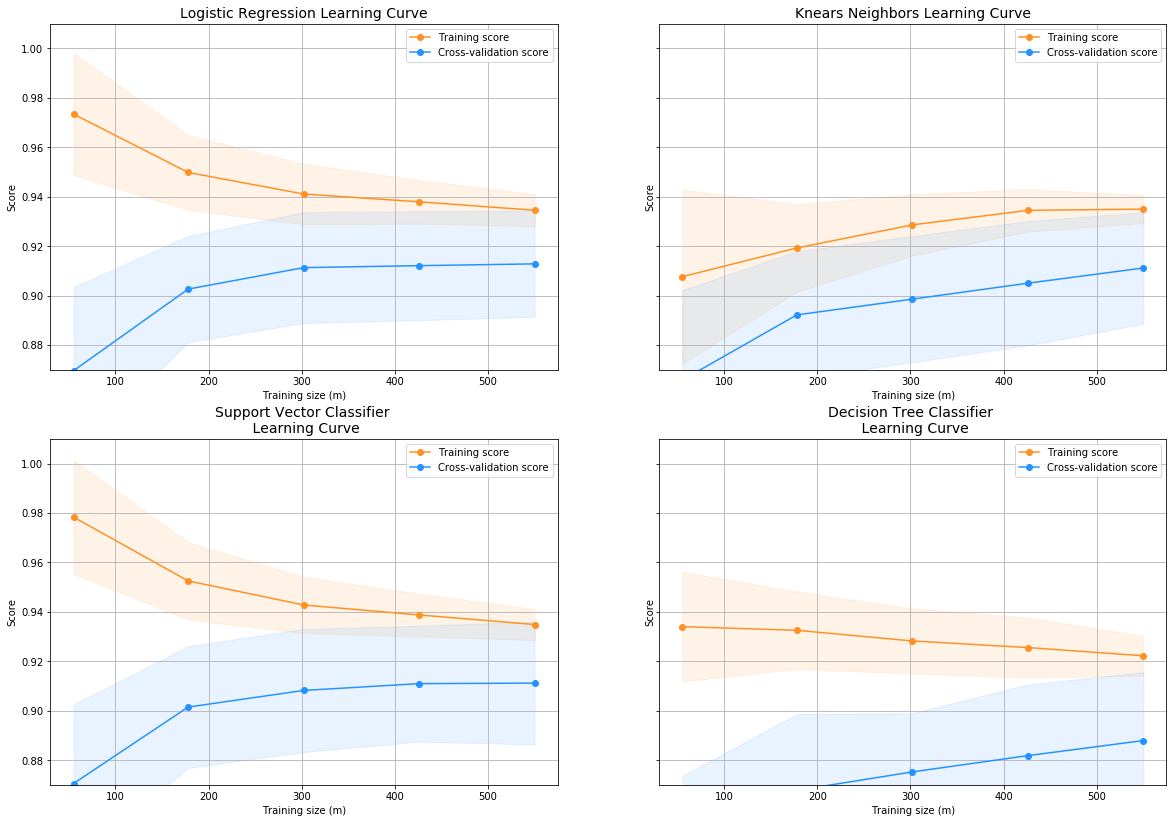

In [35]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(classifiers["Logistic Regression"],classifiers["KNN"], classifiers["Support Vector Machine"], classifiers["Decision Tree Algorithm"], X_train, Y_train, (0.87, 1.01), cv=cv, n_jobs=4)

Therefore we observe that KNN is a bit overfitted then the other models and Logistic Regression performs the best.

<h1> ROC_AUC_SCORE </h1>

In [36]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(classifiers["Logistic Regression"], X_train, Y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(classifiers["KNN"], X_train, Y_train, cv=5)

svc_pred = cross_val_predict(classifiers["Support Vector Machine"], X_train, Y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(classifiers["Decision Tree Algorithm"], X_train, Y_train, cv=5)
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(Y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(Y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(Y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(Y_train, tree_pred))

Logistic Regression:  0.9660024338302403
KNears Neighbors:  0.9088074231822331
Support Vector Classifier:  0.9633657844032045
Decision Tree Classifier:  0.8970439103539196


In [37]:
#Saving training data in pickle
pickle_out = open("X_train.pickle","wb")
pickle.dump(X_train,pickle_out)
pickle_out.close()

In [38]:
#Saving testing data in pickle
pickle_out = open("X_test.pickle","wb")
pickle.dump(X_test,pickle_out)
pickle_out.close()